In [4]:
!ls -lh maestro-v3.0.0.zip

-rw-r--r-- 1 vkomma 100018700 7.0M Jun  2 03:24 maestro-v3.0.0.zip


In [9]:
!pip install pretty_midi

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
#LSTM model: 

In [11]:
import os
import pretty_midi
import torch
from tqdm import tqdm

SEQ_LEN = 256
VOCAB_SIZE = 128

def extract_melody_harmony_from_midi(midi_file, seq_len=SEQ_LEN):
    try:
        midi = pretty_midi.PrettyMIDI(midi_file)
        notes = []
        for inst in midi.instruments:
            if not inst.is_drum:
                notes.extend(inst.notes)
        if len(notes) < seq_len:
            return None

        notes.sort(key=lambda n: n.start)
        start_time = notes[0].start
        end_time = notes[-1].end
        time_step = (end_time - start_time) / seq_len
        if time_step == 0:
            return None

        melody = [0] * seq_len
        harmony = [[0] * VOCAB_SIZE for _ in range(seq_len)]

        for note in notes:
            idx = int((note.start - start_time) / time_step)
            if 0 <= idx < seq_len and 0 <= note.pitch < VOCAB_SIZE:
                harmony[idx][note.pitch] = 1

        for i in range(seq_len):
            active = [p for p, v in enumerate(harmony[i]) if v]
            melody[i] = max(active) if active else 0

        return melody, harmony
    except:
        return None

def extract_from_folder(folder):
    pairs = []
    for root, _, files in os.walk(folder):
        for file in tqdm(files):
            if file.endswith(".mid") or file.endswith(".midi"):
                result = extract_melody_harmony_from_midi(os.path.join(root, file))
                if result:
                    pairs.append(result)
    print(f"✅ Extracted {len(pairs)} melody-harmony pairs")
    return pairs


In [14]:
import os
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pretty_midi
from tqdm import tqdm

# ----- CONFIG -----
SEQ_LEN = 256
VOCAB_SIZE = 128
HIDDEN_SIZE = 256
BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 0.001

# ----- DATASET -----
class MaestroDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        melody, harmony = self.pairs[idx]
        return torch.tensor(melody, dtype=torch.long), torch.tensor(harmony, dtype=torch.float32)

# ----- MODEL -----
class ChordLSTM(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, vocab_size)

    def forward(self, x):
        x = self.embed(x)
        out, _ = self.lstm(x)
        logits = self.fc(out)
        return torch.sigmoid(logits)

# ----- TRAINING LOOP -----
def train(model, dataloader, epochs=EPOCHS):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    loss_fn = nn.BCELoss()

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        print(f"\n🎵 Epoch {epoch}/{epochs}")
        for melody, harmony in dataloader:
            melody, harmony = melody.to(device), harmony.to(device)
            pred = model(melody)
            loss = loss_fn(pred, harmony)
            opt.zero_grad()
            loss.backward()
            opt.step()
            total_loss += loss.item()
        print(f"✅ Avg Loss: {total_loss / len(dataloader):.4f}")

# ----- GENERATION -----
def generate_chords(model, melody_seq, temperature=1.0):
    device = next(model.parameters()).device
    model.eval()
    with torch.no_grad():
        inp = melody_seq.clone().detach().unsqueeze(0).to(device)
        logits = model(inp).squeeze(0)
        probs = torch.sigmoid(logits / temperature)
        sampled = (probs > 0.5).int().tolist()
        return sampled

# ----- SAVE TO MIDI -----
def save_midi_with_chords(melody_seq, harmony_matrix, filename="output_song.mid"):
    midi = pretty_midi.PrettyMIDI()
    piano = pretty_midi.Instrument(program=0)

    time = 0.0
    for i, melody_note in enumerate(melody_seq):
        dur = random.choice([0.125, 0.25, 0.375, 0.5])  # dynamic tempo
        end = time + dur

        if melody_note > 0:
            piano.notes.append(pretty_midi.Note(velocity=100, pitch=melody_note, start=time, end=end))

        # Add 1–3 top harmony notes
        active = [(p, v) for p, v in enumerate(harmony_matrix[i]) if v]
        top_pitches = sorted([p for p, _ in active])[:3]
        for j, pitch in enumerate(top_pitches):
            offset = j * 0.03
            piano.notes.append(pretty_midi.Note(velocity=80, pitch=pitch, start=time + offset, end=end))

        time = end

    midi.instruments.append(piano)
    midi.write(filename)
    print(f"🎼 Saved to {filename}")



In [ ]:
#data extraction and code running line.

In [3]:
pairs = extract_from_folder("maestro/maestro-v3.0.0")
dataset = MaestroDataset(pairs)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

model = ChordLSTM(VOCAB_SIZE, HIDDEN_SIZE)
train(model, loader)

for i in range(6):
    melody_sample, _ = random.choice(dataset)
    harmony = generate_chords(model, melody_sample)
    save_midi_with_chords(melody_sample.tolist(), harmony, f"final_song_{i+1}.mid")


100%|██████████| 132/132 [00:28<00:00,  4.66it/s]


✅ Extracted 1275 melody-harmony pairs

🎵 Epoch 1/10
✅ Avg Loss: 0.2429

🎵 Epoch 2/10
✅ Avg Loss: 0.1717

🎵 Epoch 3/10
✅ Avg Loss: 0.1637

🎵 Epoch 4/10
✅ Avg Loss: 0.1597

🎵 Epoch 5/10
✅ Avg Loss: 0.1571

🎵 Epoch 6/10
✅ Avg Loss: 0.1551

🎵 Epoch 7/10
✅ Avg Loss: 0.1536

🎵 Epoch 8/10
✅ Avg Loss: 0.1520

🎵 Epoch 9/10
✅ Avg Loss: 0.1510

🎵 Epoch 10/10
✅ Avg Loss: 0.1496
🎼 Saved: final_song_1.mid
🎼 Saved: final_song_2.mid
🎼 Saved: final_song_3.mid
🎼 Saved: final_song_4.mid
🎼 Saved: final_song_5.mid
🎼 Saved: final_song_6.mid


In [ ]:
#Hidden Markov Model

In [18]:
from collections import defaultdict, Counter
import numpy as np
import random

# ----- BUILD MELODY → HARMONY COUNTS -----
melody_to_harmony_counts = defaultdict(Counter)

for melody, harmony in dataset:
    for m, h in zip(melody.tolist(), harmony.tolist()):
        pitches = tuple(i for i, v in enumerate(h) if v > 0)
        melody_to_harmony_counts[m].update([pitches])

# ----- CONVERT TO PROBABILITIES -----
melody_to_harmony_probs = {}
for m, counter in melody_to_harmony_counts.items():
    total = sum(counter.values())
    melody_to_harmony_probs[m] = {
        chords: count / total for chords, count in counter.items()
    }

# ----- HMM INFERENCE FUNCTION -----
def hmm_generate_harmony(melody_seq):
    harmony_seq = []
    for m in melody_seq:
        chord_probs = melody_to_harmony_probs.get(m, {})
        if chord_probs:
            chords = random.choices(list(chord_probs.keys()), weights=chord_probs.values())[0]
        else:
            chords = ()
        onehot = [0] * VOCAB_SIZE
        for p in chords:
            onehot[p] = 1
        harmony_seq.append(onehot)
    return harmony_seq


In [19]:
melody_sample, _ = random.choice(dataset)
hmm_harmony = hmm_generate_harmony(melody_sample.tolist())
save_midi_with_chords(melody_sample.tolist(), hmm_harmony, "hmm_baseline_song.mid")

🎼 Saved to hmm_baseline_song.mid


In [20]:
melody_sample, _ = random.choice(dataset)
hmm_harmony = hmm_generate_harmony(melody_sample.tolist())
save_midi_with_chords(melody_sample.tolist(), hmm_harmony, "hmm_baseline_song2.mid")

🎼 Saved to hmm_baseline_song2.mid


In [ ]:
#data distribution graphs.

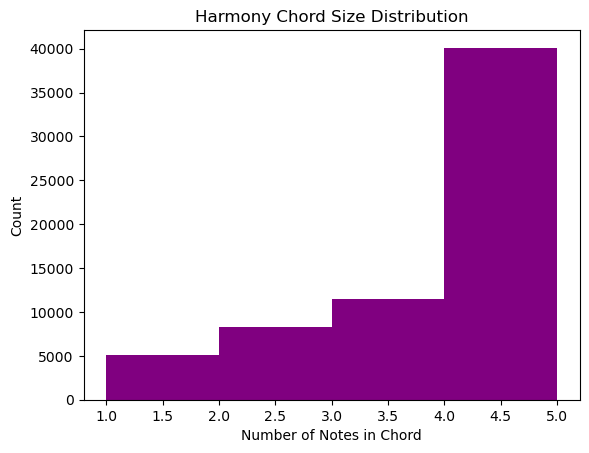

In [23]:
chord_sizes = [sum(harmony) for _, harmony in dataset for harmony in harmony.tolist()]
plt.hist(chord_sizes, bins=range(1, 6), color='purple')
plt.title("Harmony Chord Size Distribution")
plt.xlabel("Number of Notes in Chord")
plt.ylabel("Count")
plt.show()

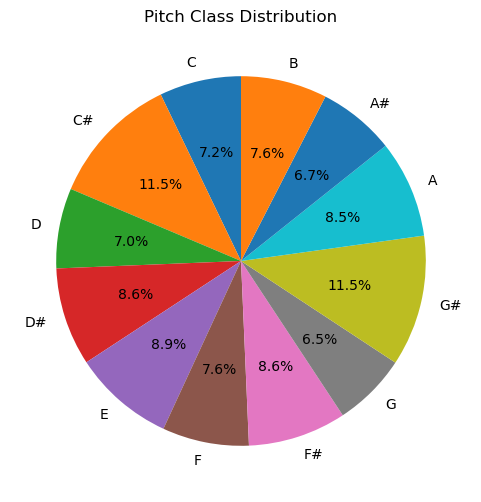

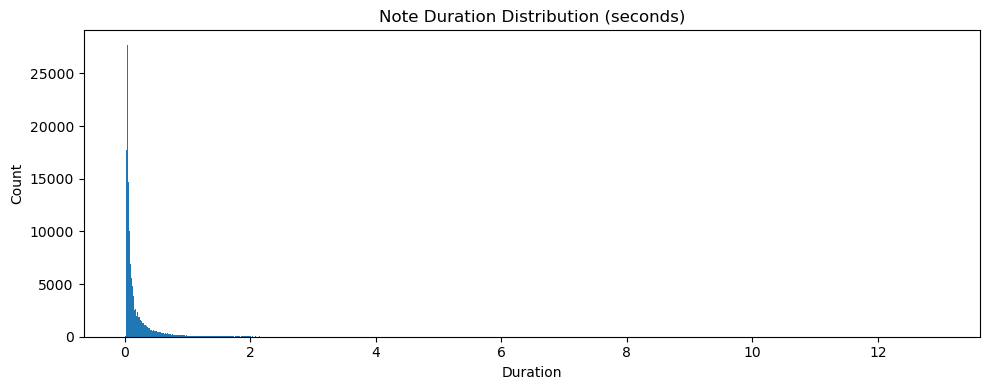

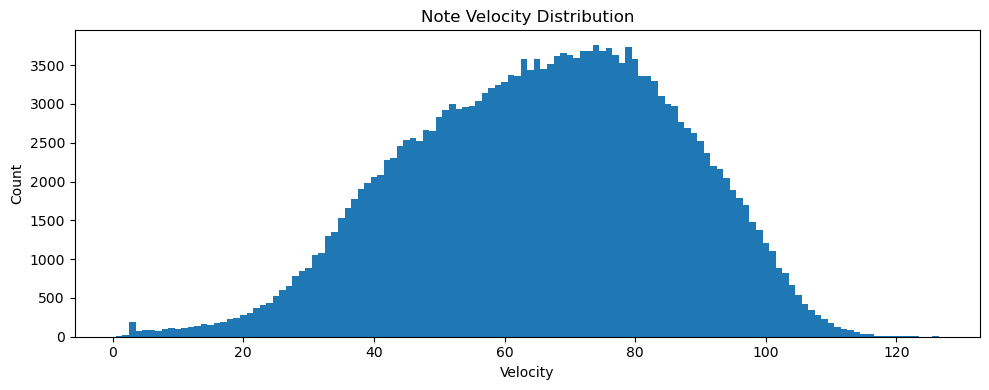

In [31]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pretty_midi
from glob import glob

# Load MIDI files
midi_files = glob("maestro/maestro-v3.0.0/**/*.midi", recursive=True)
midi_files = midi_files[:20]  # sample a few files

pitch_classes = np.zeros(12)
duration_bins = {}
velocity_bins = {}

for path in midi_files:
    try:
        midi = pretty_midi.PrettyMIDI(path)
        for inst in midi.instruments:
            for note in inst.notes:
                # --- Pitch class ---
                pitch_class = note.pitch % 12
                pitch_classes[pitch_class] += 1

                # --- Duration ---
                duration = note.end - note.start
                duration_rounded = round(duration, 2)
                duration_bins[duration_rounded] = duration_bins.get(duration_rounded, 0) + 1

                # --- Velocity ---
                velocity = note.velocity
                velocity_bins[velocity] = velocity_bins.get(velocity, 0) + 1
    except Exception as e:
        print(f"Skipped {path}: {e}")

# Normalize pitch classes
pitch_classes /= pitch_classes.sum()

# ----- PITCH CLASS DISTRIBUTION -----
labels = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
plt.figure(figsize=(6, 6))
plt.pie(pitch_classes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Pitch Class Distribution")
plt.show()

# ----- NOTE DURATION DISTRIBUTION -----
sorted_durations = sorted(duration_bins.items())
dur_x = [x[0] for x in sorted_durations]
dur_y = [x[1] for x in sorted_durations]

plt.figure(figsize=(10, 4))
plt.bar(dur_x, dur_y, width=0.01)
plt.title("Note Duration Distribution (seconds)")
plt.xlabel("Duration")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# ----- VELOCITY DISTRIBUTION -----
sorted_velocities = sorted(velocity_bins.items())
vel_x = [x[0] for x in sorted_velocities]
vel_y = [x[1] for x in sorted_velocities]

plt.figure(figsize=(10, 4))
plt.bar(vel_x, vel_y, width=1)
plt.title("Note Velocity Distribution")
plt.xlabel("Velocity")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
